## Impressions and Reviews  
- ip-app 당 channel, ip-day-hour 당 channel, ip-app-os 당 channel 변수 생성
- embedding 후 concat을 통하여 binary cls pred

In [ ]:
# good day, my friends
# in this kernel we try to continue development of DL models
# thanks for people who share his works. i hope together we can create smth interest

# https://www.kaggle.com/baomengjiao/embedding-with-neural-network
# https://www.kaggle.com/gpradk/keras-starter-nn-with-embeddings
# https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-auc-0-9787
# https://www.kaggle.com/rteja1113/lightgbm-with-count-features
# https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
# https://www.kaggle.com/isaienkov/rnn-with-keras-ridge-sgdr-0-43553
# https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755/versions#base=2202774&new=2519287

print ('Good luck')

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'
import gc

path = '../input/'
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
print('load train....')
# we save only day 9
train_df = pd.read_csv(path+"train.csv", dtype=dtypes, skiprows = range(1, 131886954), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
print('load test....')
test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
len_train = len(train_df)
train_df=train_df.append(test_df)
del test_df; gc.collect()

# 시간, 날짜 변수
print('hour, day, wday....')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['wday']  = pd.to_datetime(train_df.click_time).dt.dayofweek.astype('uint8')

# ip-day-hour 당 channel 변수
print('grouping by ip-day-hour combination....')
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
del gp; gc.collect()

# ip-app 당 channel 변수
print('group by ip-app combination....')
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp; gc.collect()

# ip-app-os 당 channel 변수
print('group by ip-app-os combination....')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp; gc.collect()

# uint16으로 변경
print("vars and data type....")
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

# 기본변수들을 label encoding
print("label encoding....")
from sklearn.preprocessing import LabelEncoder
train_df[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)

print ('final part of preparation....')
test_df = train_df[len_train:]
train_df = train_df[:len_train]
y_train = train_df['is_attributed'].values
train_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)

In [ ]:
# 변수들 embedding -> concat -> dnn (binary cls)
print ('neural network....')
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

max_app = np.max([train_df['app'].max(), test_df['app'].max()])+1
max_ch = np.max([train_df['channel'].max(), test_df['channel'].max()])+1
max_dev = np.max([train_df['device'].max(), test_df['device'].max()])+1
max_os = np.max([train_df['os'].max(), test_df['os'].max()])+1
max_h = np.max([train_df['hour'].max(), test_df['hour'].max()])+1
max_d = np.max([train_df['day'].max(), test_df['day'].max()])+1
max_wd = np.max([train_df['wday'].max(), test_df['wday'].max()])+1
max_qty = np.max([train_df['qty'].max(), test_df['qty'].max()])+1
max_c1 = np.max([train_df['ip_app_count'].max(), test_df['ip_app_count'].max()])+1
max_c2 = np.max([train_df['ip_app_os_count'].max(), test_df['ip_app_os_count'].max()])+1

def get_keras_data(dataset):
    X = {
        'app': np.array(dataset.app),
        'ch': np.array(dataset.channel),
        'dev': np.array(dataset.device),
        'os': np.array(dataset.os),
        'h': np.array(dataset.hour),
        'd': np.array(dataset.day),
        'wd': np.array(dataset.wday),
        'qty': np.array(dataset.qty),
        'c1': np.array(dataset.ip_app_count),
        'c2': np.array(dataset.ip_app_os_count)
    }
    return X
train_df = get_keras_data(train_df)

emb_n = 50
dense_n = 1000
in_app = Input(shape=[1], name = 'app')
emb_app = Embedding(max_app, emb_n)(in_app)
in_ch = Input(shape=[1], name = 'ch')
emb_ch = Embedding(max_ch, emb_n)(in_ch)
in_dev = Input(shape=[1], name = 'dev')
emb_dev = Embedding(max_dev, emb_n)(in_dev)
in_os = Input(shape=[1], name = 'os')
emb_os = Embedding(max_os, emb_n)(in_os)
in_h = Input(shape=[1], name = 'h')
emb_h = Embedding(max_h, emb_n)(in_h) 
in_d = Input(shape=[1], name = 'd')
emb_d = Embedding(max_d, emb_n)(in_d) 
in_wd = Input(shape=[1], name = 'wd')
emb_wd = Embedding(max_wd, emb_n)(in_wd) 
in_qty = Input(shape=[1], name = 'qty')
emb_qty = Embedding(max_qty, emb_n)(in_qty) 
in_c1 = Input(shape=[1], name = 'c1')
emb_c1 = Embedding(max_c1, emb_n)(in_c1) 
in_c2 = Input(shape=[1], name = 'c2')
emb_c2 = Embedding(max_c2, emb_n)(in_c2) 

fe = concatenate([(emb_app), (emb_ch), (emb_dev), (emb_os), (emb_h), 
                 (emb_d), (emb_wd), (emb_qty), (emb_c1), (emb_c2)])

s_dout = SpatialDropout1D(0.2)(fe)

x = Flatten()(s_dout)
x = Dropout(0.2)(Dense(dense_n,activation='relu')(x))
x = Dropout(0.2)(Dense(dense_n,activation='relu')(x))
outp = Dense(1,activation='sigmoid')(x)
model = Model(inputs=[in_app,in_ch,in_dev,in_os,in_h,in_d,in_wd,in_qty,in_c1,in_c2], outputs=outp)

batch_size = 20000
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1

steps = int(len(train_df) / batch_size) * epochs
lr_init, lr_fin = 0.001, 0.0001

lr_decay = exp_decay(lr_init, lr_fin, steps)

optimizer_adam = Adam(lr=0.001, decay=lr_decay)

model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])

model.summary()

model.fit(train_df, y_train, batch_size=batch_size, epochs=2, shuffle=True, verbose=2)
del train_df, y_train; gc.collect()
model.save_weights('dl_support.h5')


In [ ]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
test_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)
test_df = get_keras_data(test_df)

print("predicting....")
sub['is_attributed'] = model.predict(test_df, batch_size=batch_size, verbose=2)
del test_df; gc.collect()
print("writing....")
sub.to_csv('dl_support.csv',index=False)



# write now i don't use validation set
# since the data is imbalanced, i can't understand how we can separate data the right way


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


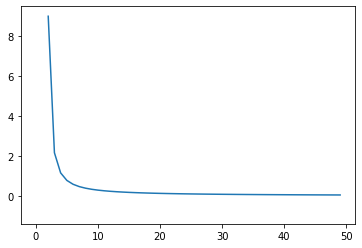

In [6]:
import matplotlib.pyplot as plt
import numpy as np
steps= np.array([i for i in range(50)])
lr_init, lr_fin = 0.001, 0.0001
plt.plot(steps, np.array((lr_init/lr_fin)**(1/(steps-1)) - 1))